**Step 1:** **Dataset Cleaning**

The features are analyzed and where necessary,  the following actions are taken:

*   Remove empty columns
*   Remove outliers
*   Remove duplicates
*   Adjust data types
*   Fill missing values
*   Normalization


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
import os
from pandas.api.types import CategoricalDtype

In [61]:
#data = pd. read_csv('/content/drive/MyDrive/green_tripdata_2015-07_trimmed.csv')
data = pd.read_csv('green_tripdata_2015-07_trimmed.csv')
data.columns = data.columns.str.replace(' ', '_').str.lower()


**Functions Used**

In [62]:
# Function to calculate IQRs
def calc_iqr(df, col, multiplier=1.5):

  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1

  print(f'using {multiplier} to determine outliers\n')
  lower_lim = round(q1 - (iqr * multiplier), 2)
  upper_lim = round(q3 + (iqr * multiplier), 2)
  lower_count = df[df[col] < lower_lim].shape[0]
  upper_count = df[df[col] > upper_lim].shape[0]


  print(f'{col} Q1:', q1)
  print(f'{col} lower limit:', lower_lim)
  print(f'{col} contains {lower_count} records below the lower limit\n')

  print(f'{col} Q3:', q3)
  print(f'upper limit:', upper_lim)
  print(f'{col} contains {upper_count} records above the upper limit\n')

  print(f'{col} contains {lower_count + upper_count} total outliers')
  print(f'this represents {round((lower_count + upper_count)/df.shape[0],2)} of the data')

  return lower_lim,upper_lim

In [63]:
scaler = MinMaxScaler()



**Feature Analysis**

In this section we will be doing univariate analysis and removing outlier/illegitimate values.



In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308333 entries, 0 to 308332
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   vendor                 308333 non-null  object 
 1   lpep_pickup_datetime   308333 non-null  object 
 2   lpep_dropoff_datetime  308333 non-null  object 
 3   store_and_fwd_flag     308333 non-null  object 
 4   rate_type              308333 non-null  object 
 5   pu_location            308333 non-null  object 
 6   do_location            308333 non-null  object 
 7   passenger_count        308241 non-null  float64
 8   trip_distance          308333 non-null  float64
 9   fare_amount            308333 non-null  float64
 10  extra                  193057 non-null  float64
 11  mta_tax                308333 non-null  float64
 12  tip_amount             308333 non-null  float64
 13  tolls_amount           308333 non-null  float64
 14  ehail_fee              0 non-null   

Preliminary Analysis:


*   The data has 2 empty features: *'congestion_surcharge'* and *'ehail_fee'*.
*   The data has 3 features with missing values: *'passenger_count'*, *'extra'* and *'payment_type'*.



In [65]:
duplicates = data.duplicated()
num_duplicates = duplicates.sum()
print(f'Number of duplicate rows: {num_duplicates}')

Number of duplicate rows: 1


In [66]:
data = data.drop_duplicates()

In [67]:
data.isna().sum()

vendor                        0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag            0
rate_type                     0
pu_location                   0
do_location                   0
passenger_count              92
trip_distance                 0
fare_amount                   0
extra                    115276
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                308332
improvement_surcharge         0
total_amount                  0
payment_type              10295
trip_type                     0
congestion_surcharge     308332
dtype: int64

Features 'extra', 'passenger_count' and 'payment_type' have missing cells which are handled in the univariate analysis.

**1. Qualitative Features**

1.1 VendorID

In [68]:
label_encoder = LabelEncoder()
data['vendor_encoded'] = label_encoder.fit_transform(data['vendor'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Vendor Label mapping:", label_mapping)

data['vendor_encoded'].value_counts()

Vendor Label mapping: {'Creative Mobile Technologies, LLC': 0, 'VeriFone Inc.': 1}


1    242164
0     66168
Name: vendor_encoded, dtype: int64

After encoding the data, the original column is dropped from the dataset.

In [69]:
data.drop(columns=['vendor'],inplace=True)

1.2 Pickup and Dropoff Datetimes

In [70]:
data['lpep_pickup_datetime'] = pd.to_datetime(data['lpep_pickup_datetime'],  format='%Y-%m-%d %H:%M:%S')
data['lpep_dropoff_datetime'] = pd.to_datetime(data['lpep_dropoff_datetime'],  format='%Y-%m-%d %H:%M:%S')

**Create Additional Date Features**

The existing data only has the datetime, so we will add the date (alone),day of week, pickup hour, whether it is rush hour or not, and the trip duration.

In [71]:
def rush_hour(pickup_time):
    if (pickup_time >= 15 and pickup_time <= 18) :
        return 1  #Rush Hour
    else:
        return 0  #Normal Hour

In [72]:
data['trip_date'] = data['lpep_pickup_datetime'].dt.date
data['trip_date'] = data['trip_date'].astype('category')

cat_strip_dow_name = CategoricalDtype(
    ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
    ordered=True
)
data['trip_dow_name'] = data['lpep_pickup_datetime'].dt.day_name()
data['trip_dow_name'] = data['trip_dow_name'].astype(cat_strip_dow_name)


In [73]:
data['rush_hour'] = data['lpep_pickup_datetime'].dt.hour.apply(rush_hour)

data['pick_up_time'] = data['lpep_pickup_datetime'].dt.hour

data['trip_duration_seconds'] = (data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime']).dt.total_seconds()  # Duration in seconds


In [74]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308332 entries, 0 to 308332
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   lpep_pickup_datetime   308332 non-null  datetime64[ns]
 1   lpep_dropoff_datetime  308332 non-null  datetime64[ns]
 2   store_and_fwd_flag     308332 non-null  object        
 3   rate_type              308332 non-null  object        
 4   pu_location            308332 non-null  object        
 5   do_location            308332 non-null  object        
 6   passenger_count        308240 non-null  float64       
 7   trip_distance          308332 non-null  float64       
 8   fare_amount            308332 non-null  float64       
 9   extra                  193056 non-null  float64       
 10  mta_tax                308332 non-null  float64       
 11  tip_amount             308332 non-null  float64       
 12  tolls_amount           308332 non-null  floa

,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,...,total_amount,payment_type,trip_type,congestion_surcharge,vendor_encoded,trip_date,trip_dow_name,rush_hour,pick_up_time,trip_duration_seconds
0,2015-07-01 00:12:55,2015-07-01 00:16:53,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,Bushwick South",1.0,0.88,5.0,0.5,...,7.88,Credit card,Street-hail,NaN,1,2015-07-01,Wednesday,0,0,238.0
1,2015-07-01 00:38:35,2015-07-01 00:49:22,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Queens,Ridgewood",1.0,3.00,11.0,0.5,...,14.76,Credit card,Street-hail,NaN,1,2015-07-01,Wednesday,0,0,647.0
2,2015-07-01 00:59:01,2015-07-01 01:04:10,N,Standard rate,"Brooklyn,Bushwick North","Brooklyn,East Williamsburg",1.0,1.61,6.5,0.5,...,7.80,Cash,Street-hail,NaN,1,2015-07-01,Wednesday,0,0,309.0
3,2015-07-01 00:48:41,2015-07-01 00:54:24,N,Standard rate,"Brooklyn,Brownsville","Brooklyn,East Flatbush/Remsen Village",1.0,0.00,5.0,0.5,...,7.56,Credit card,Street-hail,NaN,1,2015-07-01,Wednesday,0,0,343.0
4,2015-07-01 00:56:28,2015-07-01 01:07:45,N,Standard rate,"Brooklyn,East Flatbush/Remsen Village","Brooklyn,Brownsville",1.0,0.00,8.0,0.5,...,11.16,Credit card,Street-hail,NaN,1,2015-07-01,Wednesday,0,0,677.0
5,2015-07-01 00:21:37,2015-07-01 00:27:49,N,Standard rate,"Queens,Steinway","Queens,Steinway",1.0,1.39,7.0,0.5,...,8.30,Cash,Street-hail,NaN,1,2015-07-01,Wednesday,0,0,372.0
6,2015-07-01 00:39:06,2015-07-01 00:41:33,N,Standard rate,"Queens,Steinway","Queens,Steinway",1.0,0.76,4.5,0.5,...,5.80,Cash,Street-hail,NaN,1,2015-07-01,Wednesday,0,0,147.0
7,2015-07-01 00:08:54,2015-07-01 00:16:45,N,Standard rate,"Brooklyn,East Williamsburg","Brooklyn,Bushwick North",5.0,1.89,8.0,0.5,...,11.16,Credit card,Street-hail,NaN,1,2015-07-01,Wednesday,0,0,471.0
8,2015-07-01 00:30:34,2015-07-01 00:37:51,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",5.0,1.12,6.5,0.5,...,9.36,Credit card,Street-hail,NaN,1,2015-07-01,Wednesday,0,0,437.0
9,2015-07-01 00:46:08,2015-07-01 00:54:06,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Bushwick South",5.0,1.47,7.5,0.5,...,9.80,Credit card,Street-hail,NaN,1,2015-07-01,Wednesday,0,0,478.0


In [75]:
data['trip_dow_name_encoded'] = label_encoder.fit_transform(data['trip_dow_name'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Day of Week Label mapping:", label_mapping)

data['trip_dow_name_encoded'].value_counts()

Day of Week Label mapping: {'Friday': 0, 'Monday': 1, 'Saturday': 2, 'Sunday': 3, 'Thursday': 4, 'Tuesday': 5, 'Wednesday': 6}


0    77191
2    55072
3    38776
4    37072
1    36380
6    33863
5    29978
Name: trip_dow_name_encoded, dtype: int64

In [76]:
data.drop(columns=['lpep_pickup_datetime'],inplace=True)
data.drop(columns=['lpep_dropoff_datetime'],inplace=True)
data.drop(columns=['trip_dow_name'],inplace=True)
data.drop(columns=['trip_date'],inplace=True)

1.3 Store and Forward Flag

In [77]:
data['store_and_fwd_flag_encoded'] = label_encoder.fit_transform(data['store_and_fwd_flag'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Store and Forward Flag mapping:", label_mapping)

data['store_and_fwd_flag_encoded'].value_counts()

Store and Forward Flag mapping: {'N': 0, 'Y': 1}


0    306379
1      1953
Name: store_and_fwd_flag_encoded, dtype: int64

In [78]:
data.drop(columns=['store_and_fwd_flag'],inplace=True)

1.4 Rate Type

In [79]:
data['rate_type_encoded'] = label_encoder.fit_transform(data['rate_type'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Rate Type Label mapping:", label_mapping)

data['rate_type_encoded'].value_counts()

Rate Type Label mapping: {'Group ride': 0, 'JFK': 1, 'Nassau or Westchester': 2, 'Negotiated fare': 3, 'Newark': 4, 'Standard rate': 5}


5    299842
3      7193
1       869
4       254
2       165
0         9
Name: rate_type_encoded, dtype: int64

In [80]:
data.drop(columns=['rate_type'],inplace=True)

1.5 Pickup and Drop off Locations

In [81]:
data['pu_location_encoded'] = label_encoder.fit_transform(data['pu_location'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Pick Up Location Label mapping:", label_mapping)

data['pu_location_encoded'].value_counts()

Pick Up Location Label mapping: {'Bronx,Allerton/Pelham Gardens': 0, 'Bronx,Bedford Park': 1, 'Bronx,Belmont': 2, 'Bronx,Bronx Park': 3, 'Bronx,Bronxdale': 4, 'Bronx,City Island': 5, 'Bronx,Claremont/Bathgate': 6, 'Bronx,Co-Op City': 7, 'Bronx,Country Club': 8, 'Bronx,Crotona Park': 9, 'Bronx,Crotona Park East': 10, 'Bronx,East Concourse/Concourse Village': 11, 'Bronx,East Tremont': 12, 'Bronx,Eastchester': 13, 'Bronx,Fordham South': 14, 'Bronx,Highbridge': 15, 'Bronx,Hunts Point': 16, 'Bronx,Kingsbridge Heights': 17, 'Bronx,Longwood': 18, 'Bronx,Melrose South': 19, 'Bronx,Morrisania/Melrose': 20, 'Bronx,Mott Haven/Port Morris': 21, 'Bronx,Mount Hope': 22, 'Bronx,Norwood': 23, 'Bronx,Parkchester': 24, 'Bronx,Pelham Bay': 25, 'Bronx,Pelham Bay Park': 26, 'Bronx,Pelham Parkway': 27, 'Bronx,Riverdale/North Riverdale/Fieldston': 28, 'Bronx,Schuylerville/Edgewater Park': 29, 'Bronx,Soundview/Bruckner': 30, 'Bronx,Soundview/Castle Hill': 31, 'Bronx,Spuyten Duyvil/Kingsbridge': 32, 'Bronx,Uni

108    15214
105    15100
100    14938
133    14372
109    12996
       ...  
126        1
121        1
130        1
166        1
202        1
Name: pu_location_encoded, Length: 213, dtype: int64

In [82]:
data.drop(columns=['pu_location'],inplace=True)

In [83]:
data['do_location_encoded'] = label_encoder.fit_transform(data['do_location'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Drop Off Location Label mapping:", label_mapping)

data['do_location_encoded'].value_counts()

Drop Off Location Label mapping: {'Bronx,Allerton/Pelham Gardens': 0, 'Bronx,Bedford Park': 1, 'Bronx,Belmont': 2, 'Bronx,Bronx Park': 3, 'Bronx,Bronxdale': 4, 'Bronx,City Island': 5, 'Bronx,Claremont/Bathgate': 6, 'Bronx,Co-Op City': 7, 'Bronx,Country Club': 8, 'Bronx,Crotona Park': 9, 'Bronx,Crotona Park East': 10, 'Bronx,East Concourse/Concourse Village': 11, 'Bronx,East Tremont': 12, 'Bronx,Eastchester': 13, 'Bronx,Fordham South': 14, 'Bronx,Highbridge': 15, 'Bronx,Hunts Point': 16, 'Bronx,Kingsbridge Heights': 17, 'Bronx,Longwood': 18, 'Bronx,Melrose South': 19, 'Bronx,Morrisania/Melrose': 20, 'Bronx,Mott Haven/Port Morris': 21, 'Bronx,Mount Hope': 22, 'Bronx,Norwood': 23, 'Bronx,Parkchester': 24, 'Bronx,Pelham Bay': 25, 'Bronx,Pelham Bay Park': 26, 'Bronx,Pelham Parkway': 27, 'Bronx,Riverdale/North Riverdale/Fieldston': 28, 'Bronx,Schuylerville/Edgewater Park': 29, 'Bronx,Soundview/Bruckner': 30, 'Bronx,Soundview/Castle Hill': 31, 'Bronx,Spuyten Duyvil/Kingsbridge': 32, 'Bronx,Un

170    9240
109    9013
115    8791
201    8600
108    7780
       ... 
245       3
252       2
240       2
239       1
247       1
Name: do_location_encoded, Length: 255, dtype: int64

In [84]:
data.drop(columns=['do_location'],inplace=True)

1.6 Trip Type

In [85]:
data['trip_type_encoded'] = label_encoder.fit_transform(data['trip_type'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Trip Type Label mapping:", label_mapping)

data['trip_type_encoded'].value_counts()

Trip Type Label mapping: {'Dispatch': 0, 'Street-hail': 1}


1    301213
0      7119
Name: trip_type_encoded, dtype: int64

In [86]:
data.drop(columns=['trip_type'],inplace=True)

1.7 Payment Type

In [87]:
data['payment_type'] =  data['payment_type'].fillna(data['payment_type'].mode()[0])

The missing cells in this feature are filled based on the mode of the feature.

In [88]:
# neg_df = data[data['fare_amount'] < 0]
# ind = neg_df[( ((neg_df['payment_type'] == "Cash") | (neg_df['payment_type'] == "Credit Card") ) & (neg_df['trip_distance'] == 0))].index
# data = data.drop(ind)

# idx2 = neg_df[( ((neg_df['payment_type'] == "Cash") | (neg_df['payment_type'] == "Credit Card") ) & (neg_df['trip_distance'] != 0))].index
# numeric = data.select_dtypes(include=['int', 'float'])
# for column in numeric:
#     for index in idx2:
#         if index in data.index:  # Check if the index exists in the DataFrame
#             data.at[index, column] = abs(data.at[index, column])


# No_charge_cond_index = data[((data['payment_type'] == 'No charge') & (data['trip_distance'] == 0) & (data['fare_amount'] < 0)) ].index
# columns_to_zero = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']

# for col in columns_to_zero:
#     for i in No_charge_cond_index:
#         data.loc[i,col] = 0


# dispute_ind = data[((data['fare_amount'] < 0) & (data['payment_type'] == 'Dispute') & (data['trip_distance'] == 0 ))].index
# data = data.drop(dispute_ind)

# copy = data.copy()

# columns_to_sum = ['fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge']
# copy['total_payment'] = copy[columns_to_sum].sum(axis=1) # Sum all except total

# diff = copy['total_payment'] - copy['total_amount']
# con_diff = diff > 0

# copy.loc[con_diff, 'total_amount'] = copy.loc[con_diff,'total_payment']
# data = copy.drop('total_payment', axis=1)


In [89]:
data['payment_type_encoded'] = label_encoder.fit_transform(data['payment_type'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Payment Type Label mapping:", label_mapping)

data['payment_type_encoded'].value_counts()

Payment Type Label mapping: {'Cash': 0, 'Credit card': 1, 'Dispute': 2, 'No charge': 3, 'Uknown': 4}


0    172629
1    133749
3      1051
2       895
4         8
Name: payment_type_encoded, dtype: int64

In [90]:
data.drop(columns=['payment_type'],inplace=True)

**2. Quantitative Features**

2.1 Ehail Fee and Congestion Surcharge

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308332 entries, 0 to 308332
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   passenger_count             308240 non-null  float64
 1   trip_distance               308332 non-null  float64
 2   fare_amount                 308332 non-null  float64
 3   extra                       193056 non-null  float64
 4   mta_tax                     308332 non-null  float64
 5   tip_amount                  308332 non-null  float64
 6   tolls_amount                308332 non-null  float64
 7   ehail_fee                   0 non-null       float64
 8   improvement_surcharge       308332 non-null  float64
 9   total_amount                308332 non-null  float64
 10  congestion_surcharge        0 non-null       float64
 11  vendor_encoded              308332 non-null  int32  
 12  rush_hour                   308332 non-null  int64  
 13  pick_up_time  

As mentioned earlier and shown above, these 2 features are empty, hence, they will be dropped.

In [92]:
data.drop(columns = ['ehail_fee', 'congestion_surcharge'], inplace = True)

**Correlation Heat Map**

Correlation between the quantitative data is obtained to give insight on the features and determine if any of the features can be dropped.

<Axes: >

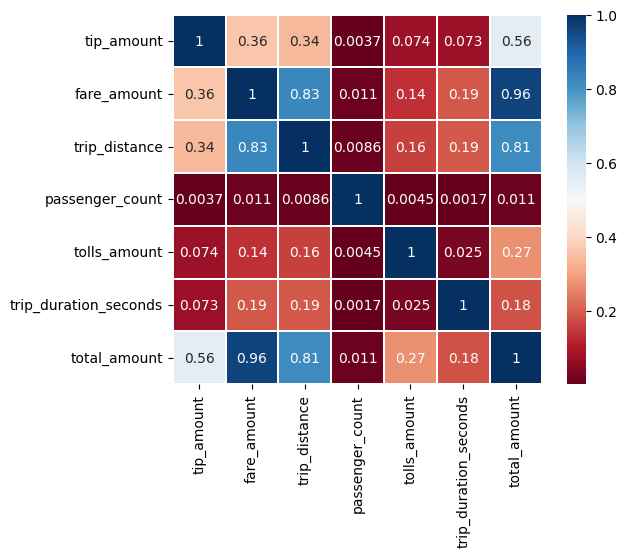

In [93]:
colormap = plt.cm.RdBu
sns.heatmap(data[['tip_amount', 'fare_amount', 'trip_distance', 'passenger_count','tolls_amount','trip_duration_seconds','total_amount']].corr(),
            linewidths=0.1,
            vmax=1.0,
            square=True,
            cmap = colormap,
            linecolor='white',
            annot=True)

There is a relatively high correlation between *fare_amount* and *trip_distance*. However, because they are also highly correlated with our output ***total_amount***, they cannot be dropped because of their importance.

*Passenger_count* has very small correlation with all the features, most importantly, the ***total_amount*** feature. Therefore, it will be dropped because it provides no significance to the output.

In [94]:
data.drop(columns=['passenger_count'],inplace=True)

2.2 Trip Distance

In [95]:
ll_trip_distance, ul_trip_distance = calc_iqr(df=data, col='trip_distance', multiplier=2)

using 2 to determine outliers

trip_distance Q1: 1.1
trip_distance lower limit: -4.18
trip_distance contains 0 records below the lower limit

trip_distance Q3: 3.74
upper limit: 9.02
trip_distance contains 13884 records above the upper limit

trip_distance contains 13884 total outliers
this represents 0.05 of the data


In [96]:
trip_distance_outliers = data[(data.trip_distance < ll_trip_distance) | (data.trip_distance > ul_trip_distance)]
data.drop(trip_distance_outliers.index, inplace=True)

In [97]:
trip_distance = data[['trip_distance']]

data['trip_distance'] = scaler.fit_transform(trip_distance)

2.3 Tolls Amount

In [98]:
unique_values = data['tolls_amount'].unique()

print(unique_values)

[0.000e+00 5.540e+00 8.000e+00 1.108e+01 2.540e+00 1.500e+00 1.175e+01
 5.330e+00 9.750e+00 1.000e-02 2.000e+00 4.000e+00 2.080e+00 9.000e+00
 5.000e-01 1.000e+00 1.180e+01 7.000e+00 6.000e+00 2.340e+00 1.050e+01
 4.160e+00 5.000e+01 1.662e+01 1.100e+01 4.500e+00 6.060e+00 3.420e+01
 5.550e+00 2.283e+01 8.000e-01 1.500e+01 3.000e+00 1.529e+01 8.080e+00
 5.500e+00 2.375e+01]


In [99]:
ll_tolls_amount, ul_tolls_amount = calc_iqr(df=data, col='tolls_amount', multiplier=2)

using 2 to determine outliers

tolls_amount Q1: 0.0
tolls_amount lower limit: 0.0
tolls_amount contains 0 records below the lower limit

tolls_amount Q3: 0.0
upper limit: 0.0
tolls_amount contains 3444 records above the upper limit

tolls_amount contains 3444 total outliers
this represents 0.01 of the data


In [100]:
# tolls_amount_outliers = data[(data.tolls_amount < ll_tolls_amount) | (data.tolls_amount > ul_tolls_amount)]
# data.drop(tolls_amount_outliers.index, inplace=True)

In [101]:
tolls_amount = data[['tolls_amount']]

data['tolls_amount'] = scaler.fit_transform(tolls_amount)

In [102]:
# data.drop(columns=['tolls_amount'],inplace=True)

2.4 Fare Amount

In [103]:
ll_fare_amount, ul_fare_amount = calc_iqr(df=data, col='fare_amount', multiplier=2)

using 2 to determine outliers

fare_amount Q1: 6.5
fare_amount lower limit: -9.5
fare_amount contains 59 records below the lower limit

fare_amount Q3: 14.5
upper limit: 30.5
fare_amount contains 3363 records above the upper limit

fare_amount contains 3422 total outliers
this represents 0.01 of the data


In [104]:
fare_amount_outliers = data[(data.fare_amount < ll_fare_amount) | (data.fare_amount > ul_fare_amount)]
data.drop(fare_amount_outliers.index, inplace=True)

In [105]:
fare_amount = data[['fare_amount']]

data['fare_amount'] = scaler.fit_transform(fare_amount)

2.5 Extra

In [106]:
data['extra'] = np.where((data['rush_hour'] == 1) & (data['extra'].isna()), 1, data['extra'])
data['extra'] = np.where((data['pick_up_time'] == 0) &  (data['pick_up_time'] == 1) & (data['pick_up_time'] == 2) & (data['pick_up_time'] == 3) & (data['pick_up_time'] == 4) & (data['pick_up_time'] == 5)  & (data['extra'].isna()), 1, data['extra'])
data['extra'] =  data['extra'].fillna(0.5)

The missing cells in the extra feature are set to 1 during rush hour and due to overnight charges. Otherwise, it is set to 0.5.

This feature only has values 0.5 and 1, hence it does not need normalization.

2.6 MTA Tax and Improvement Surcharge

In [107]:
data['mta_tax'].value_counts()

 0.5    284521
 0.0      6065
-0.5       439
 1.0         1
Name: mta_tax, dtype: int64

These features are already within the range [0,1], hence they do not need normalization.

2.7 Tip Amount

In [108]:
ll_tip_amount, ul_tip_amount = calc_iqr(df=data, col='tip_amount', multiplier=2)

using 2 to determine outliers

tip_amount Q1: 0.0
tip_amount lower limit: -3.72
tip_amount contains 0 records below the lower limit

tip_amount Q3: 1.86
upper limit: 5.58
tip_amount contains 5291 records above the upper limit

tip_amount contains 5291 total outliers
this represents 0.02 of the data


In [109]:
tip_amount_outliers = data[(data.tip_amount < ll_tip_amount) | (data.tip_amount > ul_tip_amount)]
data.drop(tip_amount_outliers.index, inplace=True)

In [110]:
tip_amount = data[['tip_amount']]

data['tip_amount'] = scaler.fit_transform(tip_amount)

2.8 Total Amount

In [111]:
ll_total_amount, ul_total_amount = calc_iqr(df=data, col='total_amount', multiplier=2)

using 2 to determine outliers

total_amount Q1: 7.8
total_amount lower limit: -8.71
total_amount contains 6 records below the lower limit

total_amount Q3: 16.055
upper limit: 32.56
total_amount contains 1483 records above the upper limit

total_amount contains 1489 total outliers
this represents 0.01 of the data


In [112]:
total_amount_outliers = data[(data.total_amount < ll_total_amount) | (data.total_amount > ul_total_amount)]
data.drop(total_amount_outliers.index, inplace=True)

In [113]:
#drop negative
neg_ind = data[(data['total_amount'] < 0)].index
data = data.drop(neg_ind)

In [114]:
#Categorizing the data into low, medium, high based on percentiles

#Get percentiles
percentiles = data['total_amount'].quantile([0.3, 0.6, 0.9])
print(f"30th percentile: {percentiles[0.3]}")
print(f"60th percentile (median): {percentiles[0.60]}")
print(f"90th percentile: {percentiles[0.9]}")

#categorize the data ====> 0:8 --> low , 8:22 --> mid , 22+ --> high
bins = [0, 8, 22, float('inf')]
labels = ['low', 'medium', 'high']
price_category = pd.cut(data['total_amount'], bins=bins, labels=labels, right=False)
data['price_category'] = price_category


data.info()
data['price_category'].value_counts()

30th percentile: 8.3
60th percentile (median): 12.74
90th percentile: 22.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 283802 entries, 0 to 308332
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   trip_distance               283802 non-null  float64 
 1   fare_amount                 283802 non-null  float64 
 2   extra                       283802 non-null  float64 
 3   mta_tax                     283802 non-null  float64 
 4   tip_amount                  283802 non-null  float64 
 5   tolls_amount                283802 non-null  float64 
 6   improvement_surcharge       283802 non-null  float64 
 7   total_amount                283802 non-null  float64 
 8   vendor_encoded              283802 non-null  int32   
 9   rush_hour                   283802 non-null  int64   
 10  pick_up_time                283802 non-null  int64   
 11  trip_duration_seconds       283802 non-nul

medium    181985
low        73413
high       28404
Name: price_category, dtype: int64

In [115]:
data.drop(columns=['total_amount'],inplace=True)

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283802 entries, 0 to 308332
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   trip_distance               283802 non-null  float64 
 1   fare_amount                 283802 non-null  float64 
 2   extra                       283802 non-null  float64 
 3   mta_tax                     283802 non-null  float64 
 4   tip_amount                  283802 non-null  float64 
 5   tolls_amount                283802 non-null  float64 
 6   improvement_surcharge       283802 non-null  float64 
 7   vendor_encoded              283802 non-null  int32   
 8   rush_hour                   283802 non-null  int64   
 9   pick_up_time                283802 non-null  int64   
 10  trip_duration_seconds       283802 non-null  float64 
 11  trip_dow_name_encoded       283802 non-null  int32   
 12  store_and_fwd_flag_encoded  283802 non-null  int32   
 13 

**Step 2: Classification Models**

Split Data (CV, train and test)

In [117]:
#Split the data into train (80%) and test (20%) sets
price_category = data['price_category']
data.drop(columns=['price_category'],inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data, price_category, test_size=0.2, random_state=42)

X_train.info()
X_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 227041 entries, 63875 to 132190
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   trip_distance               227041 non-null  float64
 1   fare_amount                 227041 non-null  float64
 2   extra                       227041 non-null  float64
 3   mta_tax                     227041 non-null  float64
 4   tip_amount                  227041 non-null  float64
 5   tolls_amount                227041 non-null  float64
 6   improvement_surcharge       227041 non-null  float64
 7   vendor_encoded              227041 non-null  int32  
 8   rush_hour                   227041 non-null  int64  
 9   pick_up_time                227041 non-null  int64  
 10  trip_duration_seconds       227041 non-null  float64
 11  trip_dow_name_encoded       227041 non-null  int32  
 12  store_and_fwd_flag_encoded  227041 non-null  int32  
 13  rate_type_

**KNN**

In [59]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import time

We began by testing various values for k to plot the error rate, using the elbow method to determine the optimal k.


In [60]:
columns = ['model name', 'accuracy', 'precision', 'recall', 'f1', 'auc']
nopcadf = pd.DataFrame(columns=columns)

# Split the data into training and testing sets
error_values = []
k_neighbors = [3, 7, 11, 19, 21 ,49,99,199,299,399]
# Vary the number of neighbors (k) and evaluate the model
for k in k_neighbors:  # Adjust the range based on your needs
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, y_train)

    KNN_start = time.time()
    price_predicted = KNN.predict(X_test)
    KNN_end = time.time()

    KNN_time = KNN_end - KNN_start

    knnaccuracy = accuracy_score(y_test, price_predicted)
    error = 1 - knnaccuracy
    error_values.append(error)
    print(f"Accuracy for {k} neighbors: ", knnaccuracy)


Accuracy for 3 neighbors:  0.8418996307066526
Accuracy for 7 neighbors:  0.8519615364030472
Accuracy for 11 neighbors:  0.8559220737516279
Accuracy for 19 neighbors:  0.8565286425347439
Accuracy for 21 neighbors:  0.8561718373682051
Accuracy for 49 neighbors:  0.8555117478101083
Accuracy for 99 neighbors:  0.8543342907605302
Accuracy for 199 neighbors:  0.8529605908693558
Accuracy for 299 neighbors:  0.8524610636362014
Accuracy for 399 neighbors:  0.8524610636362014


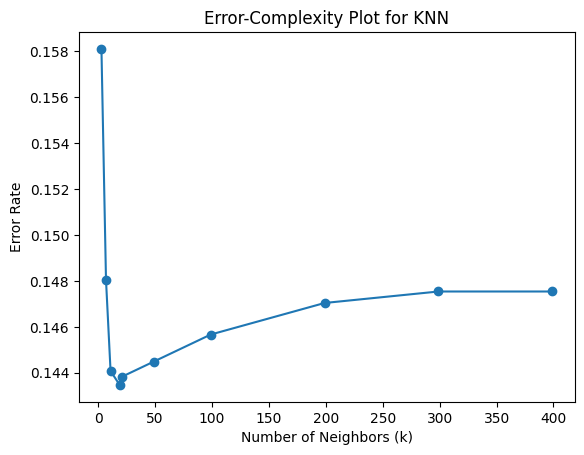

In [61]:
# Plot the error-complexity curve
plt.plot(k_neighbors, error_values, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error Rate')
plt.title('Error-Complexity Plot for KNN')
plt.show()

We used the optimal to train the model, then test it. Afterwards, I used the 5 evaluation metrics for classification which are accuracy, recall, precision, f1 score and ROC-AUC.

Accuracy: The overall accuracy of the model is 85.7%.

In [62]:
optimal_k = k_neighbors[np.argmin(error_values)] # one of the low points of error complexity --> take larger model is already small
print(f'Optimal K: {optimal_k}')
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train, y_train)
price_predicted = knn_model.predict(X_test)

# Evaluate the model
knnaccuracy = accuracy_score(y_test, price_predicted)
conf_matrix = confusion_matrix(y_test, price_predicted)
class_report = classification_report(y_test, price_predicted, target_names=np.unique(y_train))

print(f'Accuracy: {knnaccuracy}')

Optimal K: 19
Accuracy: 0.8565286425347439


Overall, the model demonstrates good performance on the "medium" and "low" classes, but there is room for improvement in accurately identifying the "high" class.

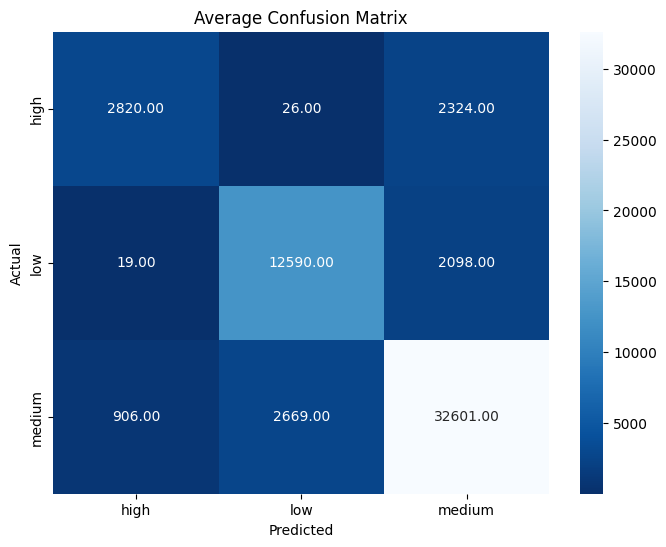

Classification Report:
              precision    recall  f1-score   support

        high       0.75      0.55      0.63      5170
         low       0.82      0.86      0.84     14707
      medium       0.88      0.90      0.89     36176

    accuracy                           0.86     56053
   macro avg       0.82      0.77      0.79     56053
weighted avg       0.85      0.86      0.85     56053



In [63]:
#Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues_r', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.title('Average Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f'Classification Report:\n{class_report}')

The average AUC is very high at 94%, which suggests that the model has an high ability to distinguish between the classes. The very high accuracy and AUC can be attributed to the high correlation between two of the numerical features, fare_amount and trip_distance. The highest AUC was for the low class.


AUC-ROC: 0.9458738480645353


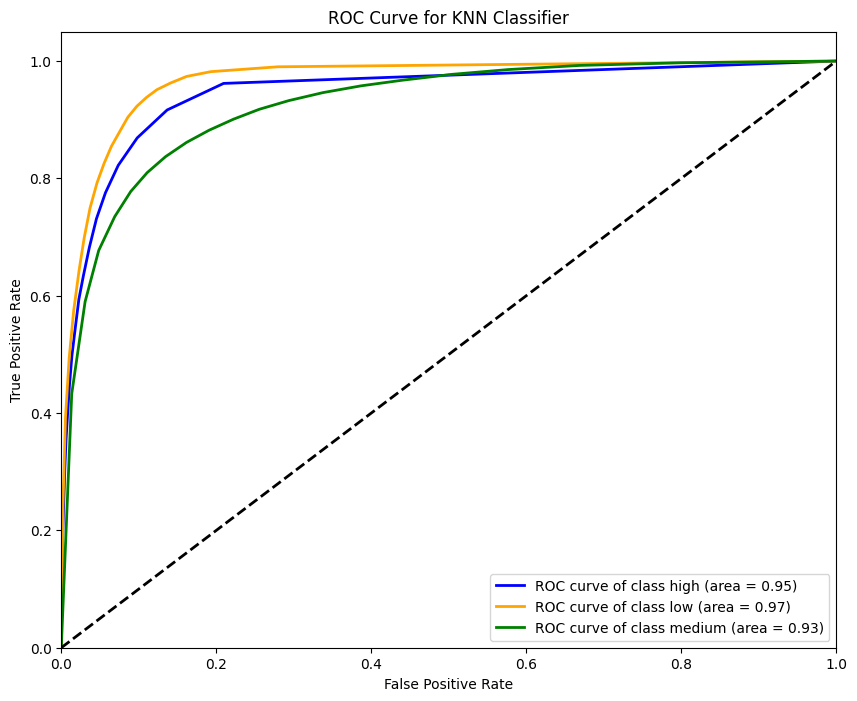

In [64]:
# Calculate AUC-ROC for each class
y_prob = knn_model.predict_proba(X_test)
auc_roc = roc_auc_score(y_test, y_prob, multi_class='ovr')  # Use 'ovo' or 'ovr' depending on your preference
print(f'AUC-ROC: {auc_roc}')


# Plot the ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(knn_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve((y_test == knn_model.classes_[i]).astype(int), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'orange', 'green']
for i, color in zip(range(len(knn_model.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(knn_model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN Classifier')
plt.legend(loc="lower right")
plt.show()

**Naive Bayes**

In Naive Bayes Classifier, Machine Learning diagonstics techniques are applied, such as Regularization and k-fold sampling of 5 splits. For each k-fold sampling iteration, the accuracy is calculated. Finally, average accuracy is calculated for all samples.
Naive Bayes accuracy = 81.24%       

Best Alpha (var_smoothing): 1e-09
GridSearchCV results:
  param_var_smoothing  mean_test_score  std_test_score  mean_train_score  \
0                 0.0         0.812417        0.004438          0.812310   
1                 0.0         0.796485        0.005737          0.796656   
2                 0.0         0.648223        0.002734          0.648305   
3            0.000001         0.648214        0.002725          0.648284   
4             0.00001         0.648214        0.002725          0.648284   
5              0.0001         0.648214        0.002725          0.648283   
6               0.001         0.648218        0.002719          0.648284   
7                0.01         0.648214        0.002714          0.648284   
8                 0.1         0.648209        0.002719          0.648282   
9                 1.0         0.648200        0.002708          0.648278   

   std_train_score  
0         0.003543  
1         0.006042  
2         0.000844  
3         0.000855  
4 

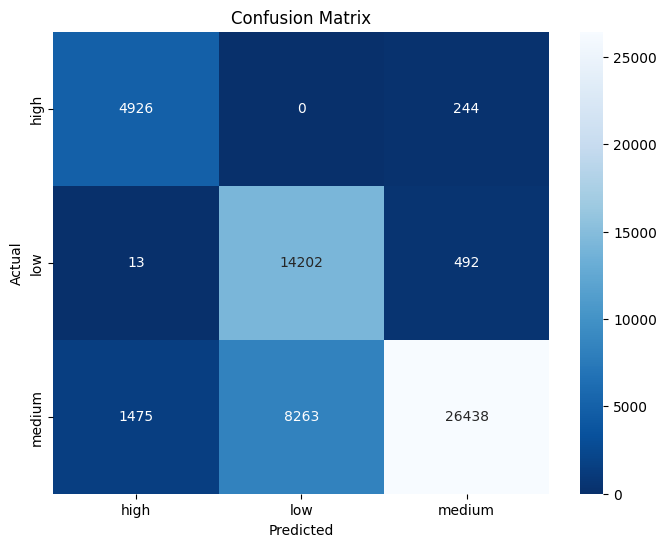

In [620]:
naive_b = GaussianNB()

param_grid = {'var_smoothing': np.logspace(-9, 0, 10)}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=naive_b, param_grid=param_grid, cv=kf, scoring='accuracy', return_train_score=True)

grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['var_smoothing']
print(f"Best Alpha (var_smoothing): {best_alpha}")

cv_results = pd.DataFrame(grid_search.cv_results_)
print("GridSearchCV results:")
print(cv_results[['param_var_smoothing', 'mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score']])

best_model = GaussianNB(var_smoothing=best_alpha)

fold_accuracies = []
fold_details = []

for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model
    best_model.fit(X_train_fold, y_train_fold)

    # Predict the test set
    y_pred = best_model.predict(X_test_fold)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_fold, y_pred)
    fold_accuracies.append(accuracy)
    fold_details.append({
        'fold': fold + 1,
        'train_index': train_index,
        'test_index': test_index,
        'accuracy': accuracy
    })

    print(f"Fold {fold + 1}:")
    print(f"Training indices: {train_index}")
    print(f"Testing indices: {test_index}")
    print(f"Accuracy: {accuracy:.4f}")
    print("-" * 40)

# Print the average accuracy
print(f"Mean cross-validation score: {np.mean(fold_accuracies):.4f}")
print(f"Standard deviation of cross-validation scores: {np.std(fold_accuracies):.4f}")

# Train the final model on the full training data
best_model.fit(X_train, y_train)
price_predicted = best_model.predict(X_test)

# Evaluate the naive bayesian classifier
# Compute the confusion matrix
cm = confusion_matrix(y_test, price_predicted)

# Print accuracy
accuracynb = accuracy_score(y_test, price_predicted)
print("Accuracy on test data:", accuracynb)

# Print classification report
print("Classification report on test data:")
print(classification_report(y_test, price_predicted))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Decision Trees**

In the implementation of the decision tree model, cross validation is implemented as an attempt to prevent overfitting and the results are analyzed to determine if it meets its purpose.

In [621]:
#Split into 60% training and 40% remaining (cross-validation + test)
X_train_dt, data_remaining, y_train_dt, price_remaining = train_test_split(
    data, price_category, test_size=0.4, random_state=42
)

#Split the remaining data into 50% cross-validation and 50% test (20% each of the original data)
data_val, X_test_dt, price_val, y_test_dt = train_test_split(
    data_remaining, price_remaining, test_size=0.5, random_state=42
)

print(f'Training set size: {len(X_train_dt)}')
print(f'Validation (cv) set size: {len(data_val)}')
print(f'Test set size: {len(X_test_dt)}')

Training set size: 168157
Validation (cv) set size: 56053
Test set size: 56053


In [622]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pandas import DataFrame

*   *X_train_dt* is used to train the model
*   *data_val* is used to determine the best depth based on the optimum accuracy
*   *X_test_dt* is used to determine the accuracy of the model


In [623]:
depth = np.array([3, 5, 10, 15, 20, 25, 30])

In [624]:
accuracy = np.array([])
accuracy1= np.array([])
for i in depth:
    DT = DecisionTreeClassifier(random_state = 42, criterion = "entropy", max_depth=i)
    DT.fit(X_train_dt, y_train_dt)
    y_pred = DT.predict(data_val)
    y_predtrain = DT.predict(X_train_dt)
    accuracy = np.append(accuracy, np.mean(y_pred == price_val))
    accuracy1 = np.append(accuracy1, np.mean(y_predtrain == y_train_dt))

In [625]:
accuracy
df = DataFrame()
df["max_depth"] = depth
df["cross_validation_accuracy"] = accuracy
df["train_accuracy"] = accuracy1
df

,max_depth,cross_validation_accuracy,train_accuracy
0,3,0.925981,0.925671
1,5,0.968673,0.967875
2,10,0.998109,0.998680
3,15,0.997984,0.999905
4,20,0.997841,1.000000
5,25,0.997841,1.000000
6,30,0.997841,1.000000


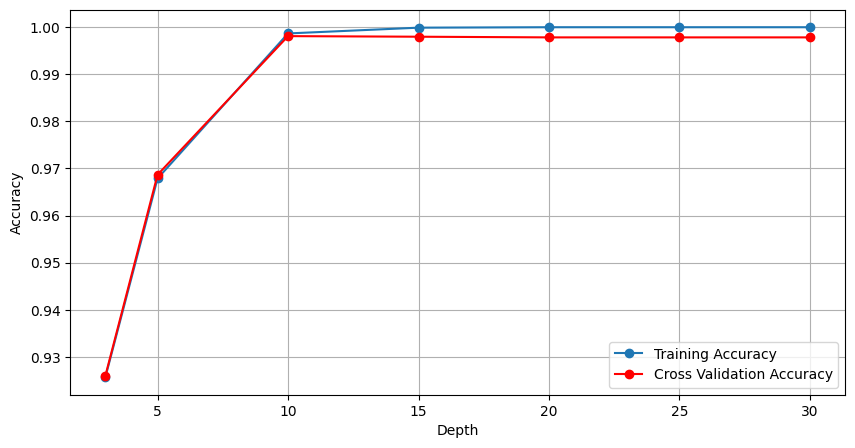

In [626]:
plt.subplots(figsize = (10,5))
plt.plot(depth, accuracy1, marker = 'o', label = "Training Accuracy")
plt.plot(depth, accuracy, marker = 'o',color = 'r', label = "Cross Validation Accuracy")

plt.grid(True)
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

A depth of 10 is the optimum depth. It has the largest cross-validation accuracy and also ensures that the number of branches are not too many to prevent overfitting.

The test data is used to obtain the overall accuracy of the model on a depth of 10.

**Chosen Desicion Tree Model**

In [627]:
test_accuracy = 0
DT = DecisionTreeClassifier(random_state = 42, criterion = "entropy", max_depth=10)
DT.fit(X_train_dt, y_train_dt)
y_pred = DT.predict(X_test_dt)
DT_accuracy = np.mean(y_pred == y_test_dt)

In [628]:
DT_accuracy

0.9979840508090557

In [629]:
print(metrics.classification_report(y_test_dt, y_pred,  target_names =np.unique(price_category)))

              precision    recall  f1-score   support

        high       0.99      0.99      0.99      5050
         low       1.00      1.00      1.00     14581
      medium       1.00      1.00      1.00     36422

    accuracy                           1.00     56053
   macro avg       1.00      1.00      1.00     56053
weighted avg       1.00      1.00      1.00     56053



The model performs well in each of the 3 classes, with excellent accuracy, recall, and F1-score. The weighted average indicates that performance was balanced across all price categories, resulting to an overall accuracy of 100%.

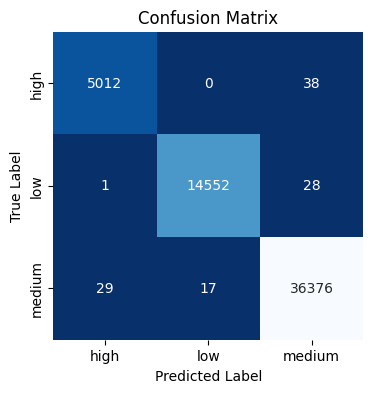

In [630]:
conf_matrix = confusion_matrix(y_test_dt, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues_r", cbar=False,  xticklabels=np.unique(price_category), yticklabels=np.unique(price_category))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The most misclassified class shows 38 instances of the class *high* being classified as *medium*.

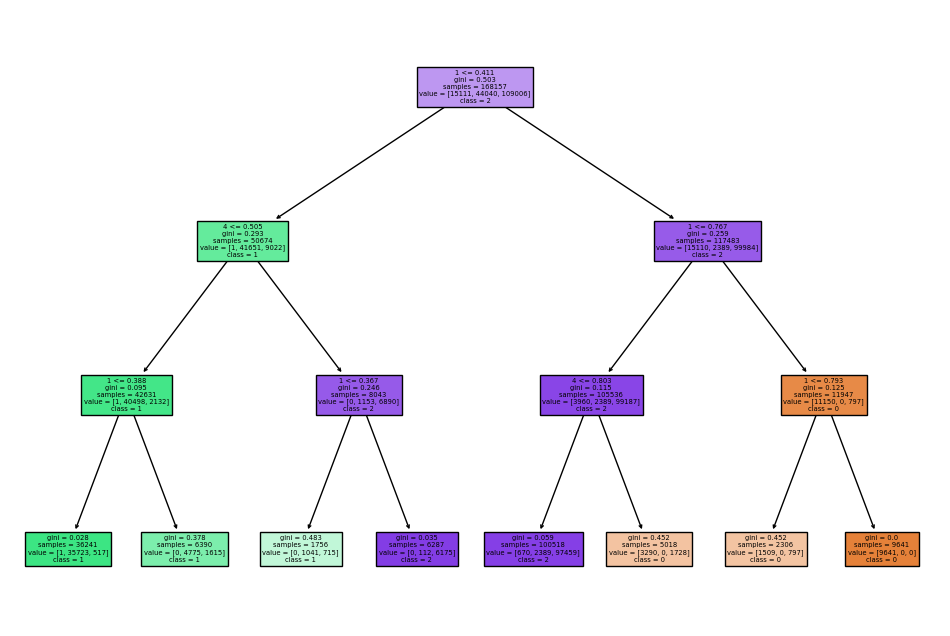

In [631]:
model = DecisionTreeClassifier(max_depth=3)
model.fit(X_train_dt, y_train_dt)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(model, filled=True, feature_names=[str(i) for i in range(X_train_dt.shape[1])], class_names=[str(i) for i in range(10)])
plt.show()

This decision tree is a visualization of our dataset for a depth of 3 briefly showing how the model splits the data and utilizing the gini index rather than the entropy.

**Random Forest**

This implementation of the random forest model runs on different number of trees and obtains the accuracy for each. We then analyze the accuracy and choose the best one.

In [632]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
import time
from sklearn import metrics

In [633]:
num_of_trees = [10, 25, 50, 100, 200, 300]  #Number of decision trees
accuracytest = []
accuracytrain = []

df = DataFrame(columns=['num_of_trees', 'test_acc', 'time'])
k = 0
for i in num_of_trees:
    RF = RandomForestClassifier(n_estimators=i, random_state=0)

    RF.fit(X_train, y_train)
    RF_start = time.time()
    y_pred = RF.predict(X_test)
    y_pred_train = RF.predict(X_train)
    RF_end = time.time()

    RF_time = RF_end - RF_start

    accuracy = accuracy_score(y_test, y_pred)
    accuracy2 = accuracy_score(y_train, y_pred_train)
    print('Accuracy for #num_of_trees',i,":",accuracy )

    accuracytest.append(accuracy)
    accuracytrain.append(accuracy2)

    df.loc[k] = [i, accuracy, RF_time]
    k += 1

Accuracy for #num_of_trees 10 : 0.9964319483346119
Accuracy for #num_of_trees 25 : 0.9968422742761315
Accuracy for #num_of_trees 50 : 0.9972704404759781
Accuracy for #num_of_trees 100 : 0.9973418015092859
Accuracy for #num_of_trees 200 : 0.9974131625425936
Accuracy for #num_of_trees 300 : 0.9975023638342283


In [634]:
df

,num_of_trees,test_acc,time
0,10.0,0.996432,0.543146
1,25.0,0.996842,0.960181
2,50.0,0.997270,1.905659
3,100.0,0.997342,4.114716
4,200.0,0.997413,8.632499
5,300.0,0.997502,12.299721


The results show that increasing the number of trees increases the accuracy but also increases the time for which the model runs. Hence, a compromise between accuracy and complexity should be made.

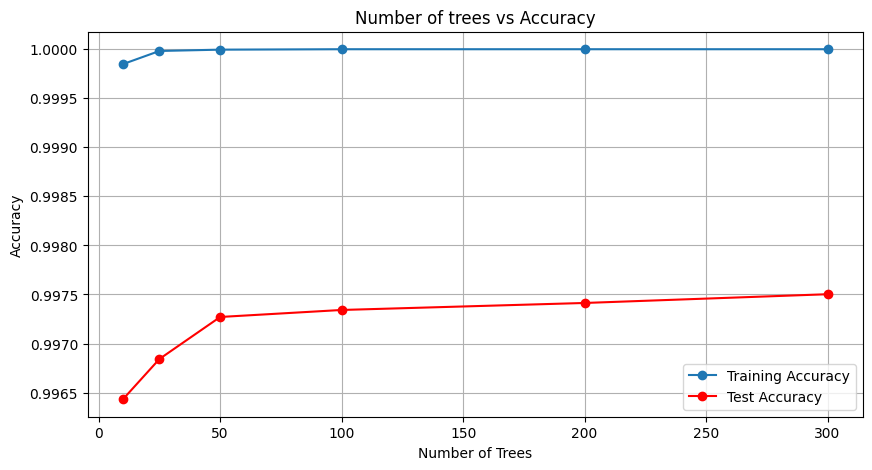

In [635]:
plt.subplots(figsize = (10,5))
plt.plot(num_of_trees, accuracytrain, marker = 'o', label = "Training Accuracy")
plt.plot(num_of_trees, accuracytest, marker = 'o',color = 'r', label = "Test Accuracy")

plt.grid(True)
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Number of trees vs Accuracy")
plt.show()

The test accuracy has a very good accuracy and is very close to the train accuracy. Hence, there is no overfitting/underfitting.

Changing the number of trees from 50 to 300 only increases the accuracy by 0.05%. Hence, 50 trees is chosen for our model as a compromise with complexity given that 99.73% accuracy is already a good percentage.



**Chosen Model**

In [636]:
RF = RandomForestClassifier(n_estimators=50)

RF.fit(X_train, y_train)
RF_start = time.time()
y_pred = RF.predict(X_test)
RF_end = time.time()

RF_time = RF_end - RF_start

accuracyrf = accuracy_score(y_test, y_pred)
print('Accuracy for #num_of_trees 50:',accuracyrf )


Accuracy for #num_of_trees 50: 0.9973239612509589


In [637]:
print(metrics.classification_report(y_test, y_pred,  target_names =np.unique(price_category)))

              precision    recall  f1-score   support

        high       1.00      0.99      0.99      5170
         low       1.00      1.00      1.00     14707
      medium       1.00      1.00      1.00     36176

    accuracy                           1.00     56053
   macro avg       1.00      1.00      1.00     56053
weighted avg       1.00      1.00      1.00     56053



The model performs well in each of the 3 classes, with excellent accuracy, recall, and F1-score. The weighted average indicates that performance was balanced across all price categories, resulting to an overall accuracy of 100%.

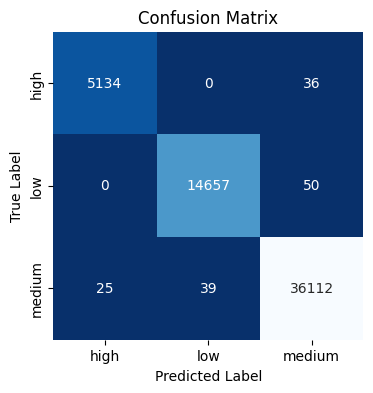

In [638]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues_r", cbar=False,  xticklabels=np.unique(price_category), yticklabels=np.unique(price_category))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The most misclassified class shows 49 instances of the class 'low' being classified as 'medium'.

**Logistic Regression**


Here, we are trying to use regularization technique to find the best hypothesis function for the logistic regression model. C is the regularization parameter ranging from 0.01 to 100. We are checking the accuracy of the model with the different C values using the test data. Then, we have used the best C value (highest accuracy) for the final model.

In [120]:
from sklearn.linear_model import LogisticRegression
import time

C = [0.01, 0.1, 1, 10, 100]
accuracytestlr = []
lrmeanse = []
df1 = pd.DataFrame(columns=['C', 'test_acc', 'time'])
k = 0
for i in C:
    LR = LogisticRegression(C=i, max_iter=1000,solver='liblinear')
    LR.fit(X_train, y_train)
    LR_start = time.time()

    y_pred = LR.predict(X_test)
    LR_end = time.time()

    LR_time = LR_end - LR_start

    lraccuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for C {i}:", lraccuracy)

    accuracytestlr.append(lraccuracy)

    df1.loc[k] = [i, lraccuracy, LR_time]
    k += 1

Accuracy for C 0.01: 0.8516587093250647
Accuracy for C 0.1: 0.8985042546819119
Accuracy for C 1: 0.9414386638713201
Accuracy for C 10: 0.9465830411726361
Accuracy for C 100: 0.9268688007610859


C=10 guarantees the best hypothesis with the highest accuracy.

In [127]:
LR = LogisticRegression(C=10, max_iter=1000,solver='liblinear')
LR.fit(X_train, y_train)
LR_start = time.time()

y_pred = LR.predict(X_test)
LR_end = time.time()

LR_time = LR_end - LR_start

lraccuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for C 10:", lraccuracy)

Accuracy for C 10: 0.9465830411726361


Confusion Matrix

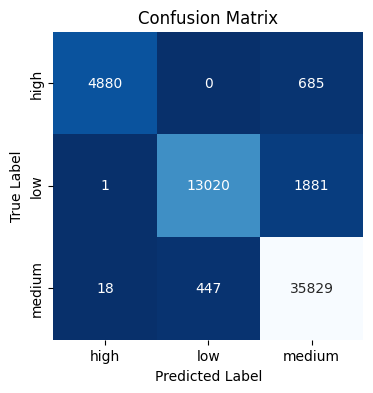

In [128]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues_r", cbar=False,  xticklabels=np.unique(price_category), yticklabels=np.unique(price_category))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()